# Assignment 3

Environment Setup & Imports

In [2]:
import sys
import os
import subprocess
import importlib.util
import re
import random
import gc
from tqdm.auto import tqdm # Use tqdm for progress bars

# --- Core Libraries Check & Install Utility ---
def safe_install_package(package_name, import_name=None):
    """Installs a package if it is not found."""
    if import_name is None:
        import_name = package_name

    if importlib.util.find_spec(import_name) is None:
        print(f"Installing missing library: {package_name}...")
        try:
            # Use sys.executable to target the current environment
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_name], stdout=subprocess.DEVNULL)
            print(f"Successfully installed {package_name}!")
        except subprocess.CalledProcessError as e:
            print(f"Failed to install {package_name}. Error: {e}")

def configure_environment():
    """Checks and installs all required ML/NLP dependencies."""
    print("Starting environment configuration...")

    required_packages = {
        'pandas': 'pandas', 'numpy': 'numpy', 'torch': 'torch',
        'nltk': 'nltk', 'gensim': 'gensim', 'scikit-learn': 'sklearn',
        'transformers': 'transformers', 'sentence-transformers': 'sentence_transformers',
        'accelerate': 'accelerate', 'matplotlib': 'matplotlib', 'seaborn': 'seaborn'
    }

    for pypi_name, import_name in required_packages.items():
        safe_install_package(pypi_name, import_name)

    # Custom handler for FAISS (GPU preferred, CPU fallback)
    if importlib.util.find_spec("faiss") is None:
        print("Installing FAISS (Vector Indexing)...")
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'faiss-gpu'], stdout=subprocess.DEVNULL)
            print("Successfully installed faiss-gpu!")
        except:
            try:
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'faiss-cpu'], stdout=subprocess.DEVNULL)
                print("Successfully installed faiss-cpu!")
            except Exception as e:
                print(f"Could not install FAISS. RAG section will fail. Error: {e}")

    # Install bitsandbytes for efficient LLM loading
    safe_install_package('bitsandbytes')

    print("Environment configuration complete.")

# ----------------------------------------------------
# EXECUTION - Configure environment first
# ----------------------------------------------------
configure_environment() # Run auto-installer

# --- Now import all necessary libraries ---
# Core ML/NLP libraries (potentially installed by configure_environment)
import numpy as np
import pandas as pd
import torch
import nltk
import gensim
import faiss
import matplotlib.pyplot as plt
import seaborn as sns

# Specific module imports
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    Trainer,
    TrainingArguments,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from sentence_transformers import SentenceTransformer

try:
    BNB_CONFIG = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    USE_4BIT = True
except ImportError:
    USE_4BIT = False
    print("Note: bitsandbytes not found. LLMs will be loaded in standard float16/bfloat16.")


# --- Global Configuration (Reproducibility & Device) ---
def setup_reproducibility(seed_val=42):
    """Sets random seeds for deterministic results."""
    global DEVICE
    global SEED
    SEED = seed_val
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        DEVICE = "cuda"
    else:
        DEVICE = "cpu"
    print(f"Using compute device: {DEVICE}")

    # Set up NLTK data path robustly
    local_nltk_path = os.path.join(os.getcwd(), 'custom_nltk_data')
    if not os.path.exists(local_nltk_path):
        os.makedirs(local_nltk_path)
    nltk.data.path.append(local_nltk_path)

    # Download required NLTK components
    required_resources = ['punkt', 'punkt_tab', 'stopwords', 'wordnet'] # Added 'punkt_tab'
    for res in required_resources:
        try:
            nltk.data.find(f'tokenizers/{res}' if 'punkt' in res or 'punkt_tab' in res else f'corpora/{res}')
        except LookupError:
            # print(f"Downloading NLTK resource: {res}...") # Removed print for cleaner output
            nltk.download(res, download_dir=local_nltk_path, quiet=True)

setup_reproducibility()

Starting environment configuration...
Installing missing library: gensim...
Installing FAISS (Vector Indexing)...
Installing missing library: bitsandbytes...
Environment configuration complete.
Using compute device: cuda


Data Loading and Feature Preparation

In [4]:
# --- Class to handle data operations (different from function-based original) ---
class FinancialTextHandler:
    """Handles loading, preprocessing, and splitting of the financial sentiment dataset."""

    def __init__(self, data_path, seed):
        self.data_path = data_path
        self.SEED = seed
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.punctuation_re = re.compile(r'[^a-zA-Z\s]') # Pre-compile regex

    def load_and_parse(self):
        """Loads data from the 'sentence@label' format file."""
        financial_sentences = []
        sentiment_labels = []

        try:
            # Check for the directory structure
            if not os.path.exists(self.data_path) and os.path.exists(os.path.basename(self.data_path)):
                print(f"File not found at '{self.data_path}'. Trying local path: '{os.path.basename(self.data_path)}'")
                actual_path = os.path.basename(self.data_path)
            elif os.path.exists(self.data_path):
                actual_path = self.data_path
            else:
                raise FileNotFoundError(f"Dataset file not found at {self.data_path} or {os.path.basename(self.data_path)}")

            with open(actual_path, 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    if '@' in line:
                        text, label = line.split('@', 1) # Split only on the first '@'
                        financial_sentences.append(text.strip())
                        sentiment_labels.append(label.strip())

            self.data_frame = pd.DataFrame({
                'full_text': financial_sentences,
                'sentiment': sentiment_labels
            })
            print(f"Data loaded successfully from {actual_path}. Total samples: {len(self.data_frame)}")
            return True
        except FileNotFoundError as e:
            print(f"ERROR: {e}. Please ensure the dataset file is accessible.")
            return False

    def clean_text_pipeline(self, text):
        """Applies cleaning, tokenization, stopword removal, and lemmatization."""
        text = text.lower()
        # 1. Remove punctuation/numbers
        text = self.punctuation_re.sub('', text)

        # 2. Tokenize
        tokens = word_tokenize(text)

        # 3. Stopword removal & Lemmatization & length filtering
        clean_tokens = [
            self.lemmatizer.lemmatize(word)
            for word in tokens
            if word not in self.stop_words and len(word) > 2
        ]

        return clean_tokens

    def execute_pipeline(self):
        """Runs the full processing and splitting pipeline."""
        if not self.load_and_parse():
            return None, None, None

        # Apply preprocessing
        print("Applying preprocessing steps (lemmatization, stopword removal)...")
        self.data_frame['tokens'] = self.data_frame['full_text'].apply(self.clean_text_pipeline)
        self.data_frame['processed_text'] = self.data_frame['tokens'].apply(lambda x: ' '.join(x))

        # EDA (Class Distribution)
        print("\n--- Initial Dataset EDA (Sentiment Distribution) ---")
        print(self.data_frame['sentiment'].value_counts())


        # Stratified Train/Test Split (80/20)
        train_set, test_set = train_test_split(
            self.data_frame,
            test_size=0.2,
            random_state=self.SEED,
            stratify=self.data_frame['sentiment']
        )
        print(f"\nTraining Set Size: {len(train_set)}, Test Set Size: {len(test_set)}")
        return train_set, test_set, self.data_frame

# ----------------------------------------------------
# EXECUTION
# ----------------------------------------------------
DATASET_FILE = "/content/dataset/Sentences_AllAgree.txt"
data_handler = FinancialTextHandler(DATASET_FILE, SEED)
train_df, test_df, full_df = data_handler.execute_pipeline()

if train_df is None:
    sys.exit("Cannot proceed without the dataset.")

Data loaded successfully from /content/dataset/Sentences_AllAgree.txt. Total samples: 2264
Applying preprocessing steps (lemmatization, stopword removal)...

--- Initial Dataset EDA (Sentiment Distribution) ---
sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Training Set Size: 1811, Test Set Size: 453


LDA Topic Modeling

In [5]:
# --- Helper to manage the LDA process ---
def perform_lda_topic_modeling(df_data, num_topics=5):
    """
    Performs LDA on the processed text tokens and calculates coherence.
    Uses Gensim.
    """
    print(f"\n--- Starting LDA Topic Modeling ({num_topics} Topics) ---")

    # 1. Prepare Corpus
    tokenized_documents = df_data['tokens'].tolist()
    vocabulary = corpora.Dictionary(tokenized_documents)

    # Filter extremes (e.g., words appearing in less than 5 docs or more than 50% of docs)
    vocabulary.filter_extremes(no_below=5, no_above=0.5)

    # Convert to Bag-of-Words (BoW)
    bow_corpus = [vocabulary.doc2bow(doc) for doc in tokenized_documents]

    # 2. Train LDA Model
    lda_trainer = LdaModel(
        corpus=bow_corpus,
        id2word=vocabulary,
        num_topics=num_topics,
        random_state=SEED,
        passes=10, # Number of training iterations
        alpha='auto'
    )

    # 3. Display Topics
    print("LDA Topic Keywords (Top 10):")
    for topic_idx, topic_words in lda_trainer.print_topics(num_words=10):
        print(f"Topic {topic_idx}: {topic_words}")

    # 4. Compute Coherence Score (c_v) - Measures the interpretability of the topics
    coherence_evaluator = CoherenceModel(
        model=lda_trainer,
        texts=tokenized_documents,
        dictionary=vocabulary,
        coherence='c_v'
    )
    coherence_score = coherence_evaluator.get_coherence()
    print(f"\nCoherence Score (c_v): {coherence_score:.4f}")

    # 5. Assign Dominant Topic
    def get_highest_topic(doc_bow):
        topic_dist = lda_trainer.get_document_topics(doc_bow)
        # Find the topic with the max probability
        if not topic_dist:
            return -1 # Sentinel for empty doc
        return max(topic_dist, key=lambda x: x[1])[0]

    # Assign dominant topic to a new column
    df_data['latent_topic'] = [get_highest_topic(vocabulary.doc2bow(doc)) for doc in tokenized_documents]

    print("\n--- Sample Dominant Topic Assignments (for verification) ---")
    print(df_data[['full_text', 'latent_topic']].head())

    return lda_trainer, vocabulary, coherence_score

# ----------------------------------------------------
# EXECUTION
# ----------------------------------------------------
# Using 5 topics as a standard starting point, consistent with typical reports
lda_model, lda_vocab, lda_coherence = perform_lda_topic_modeling(full_df)


--- Starting LDA Topic Modeling (5 Topics) ---
LDA Topic Keywords (Top 10):
Topic 0: 0.088*"mln" + 0.050*"euro" + 0.026*"finnish" + 0.021*"oyj" + 0.018*"helsinki" + 0.018*"share" + 0.016*"said" + 0.015*"stock" + 0.014*"company" + 0.013*"profit"
Topic 1: 0.054*"sale" + 0.039*"million" + 0.038*"net" + 0.023*"finnish" + 0.023*"year" + 0.022*"percent" + 0.020*"said" + 0.019*"market" + 0.017*"first" + 0.015*"finland"
Topic 2: 0.036*"company" + 0.022*"share" + 0.016*"total" + 0.016*"said" + 0.014*"value" + 0.012*"cost" + 0.012*"capital" + 0.012*"investment" + 0.010*"eurm" + 0.009*"operation"
Topic 3: 0.202*"eur" + 0.063*"profit" + 0.046*"operating" + 0.038*"quarter" + 0.034*"period" + 0.033*"net" + 0.027*"sale" + 0.025*"decreased" + 0.022*"million" + 0.019*"corresponding"
Topic 4: 0.020*"service" + 0.015*"market" + 0.014*"expected" + 0.013*"company" + 0.013*"building" + 0.013*"price" + 0.013*"finland" + 0.012*"also" + 0.011*"mobile" + 0.011*"nokia"

Coherence Score (c_v): 0.3898

--- Sample

Sentiment Analysis Comparative Pipeline

*Utility Functions (Metrics & Plotting)*

In [6]:
# --- Label Mapping ---
SENTIMENT_MAP = {'positive': 0, 'negative': 1, 'neutral': 2}
INV_SENTIMENT_MAP = {v: k for k, v in SENTIMENT_MAP.items()}
LABEL_ORDER = list(SENTIMENT_MAP.keys()) # For consistent CM plotting

class MetricsReporter:
    """Calculates and reports performance metrics, including the Confusion Matrix plot."""

    def __init__(self, label_map, label_order):
        self.label_map = label_map
        self.label_order = label_order

    def get_all_metrics(self, y_true, y_pred, model_name):
        """Calculates and prints Accuracy, Precision, Recall, and F1."""
        print(f"\n=== {model_name} Performance Metrics ===")

        acc = accuracy_score(y_true, y_pred)
        # Use 'weighted' average for multi-class imbalanced data
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted', zero_division=0, labels=self.label_order
        )

        print(f"Accuracy: {acc:.4f}, Precision: {p:.4f}, Recall: {r:.4f}, F1: {f1:.4f}")
        return acc, p, r, f1

    def plot_confusion_matrix(self, y_true, y_pred, model_name):
        """Plots the confusion matrix using seaborn/matplotlib."""
        cm = confusion_matrix(y_true, y_pred, labels=self.label_order)

        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=self.label_order,
            yticklabels=self.label_order
        )
        plt.title(f'Confusion Matrix: {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

# ----------------------------------------------------
# EXECUTION
# ----------------------------------------------------
metric_tool = MetricsReporter(SENTIMENT_MAP, LABEL_ORDER)
test_labels = test_df['sentiment'].tolist()
global_accuracies = {}

*FinBERT (Domain-Specific Transformer)*


--- Running FinBERT (ProsusAI/finbert) Inference ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

FinBERT Prediction:   0%|          | 0/29 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


=== FinBERT (ProsusAI) Performance Metrics ===
Accuracy: 0.9691, Precision: 0.9712, Recall: 0.9691, F1: 0.9695


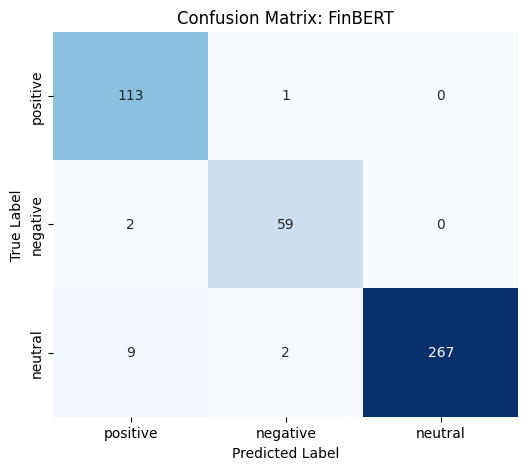

In [7]:
# --- FinBERT Implementation ---
FINBERT_MODEL = "ProsusAI/finbert"

def finbert_inference(texts, model_name=FINBERT_MODEL, batch_size=16):
    """Loads FinBERT and performs batch inference manually."""
    print(f"\n--- Running FinBERT ({model_name}) Inference ---")

    # 1. Load Model and Tokenizer
    fin_tokenizer = AutoTokenizer.from_pretrained(model_name)
    fin_model = AutoModelForSequenceClassification.from_pretrained(model_name).to(DEVICE)
    fin_model.eval() # Set to evaluation mode

    predictions = []

    # 2. Manual Batch Processing
    for i in tqdm(range(0, len(texts), batch_size), desc="FinBERT Prediction"):
        batch_texts = texts[i:i + batch_size]

        # Tokenize and move to device
        encoded_inputs = fin_tokenizer(
            batch_texts,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=128
        ).to(DEVICE)

        with torch.no_grad():
            outputs = fin_model(**encoded_inputs)

        # Get the predicted class index (max logit)
        batch_preds = torch.argmax(outputs.logits, dim=-1).cpu().tolist()
        predictions.extend(batch_preds)

    # 3. Map indices back to labels
    label_preds = [fin_model.config.id2label[p] for p in predictions]

    # Cleanup memory
    del fin_model, fin_tokenizer, encoded_inputs, outputs
    if DEVICE == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

    return label_preds

# ----------------------------------------------------
# EXECUTION
# ----------------------------------------------------
finbert_preds = finbert_inference(test_df['full_text'].tolist())
acc, _, _, _ = metric_tool.get_all_metrics(test_labels, finbert_preds, "FinBERT (ProsusAI)")
metric_tool.plot_confusion_matrix(test_labels, finbert_preds, "FinBERT")
global_accuracies['FinBERT'] = acc

*Local LLM (Zero-Shot)*


--- Running Local LLM (microsoft/phi-2) Zero-Shot ---


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


LLM Zero-Shot:   0%|          | 0/50 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



=== Local LLM (Zero-Shot) on 50 Samples Performance Metrics ===
Accuracy: 0.6800, Precision: 0.6913, Recall: 0.6800, F1: 0.6752


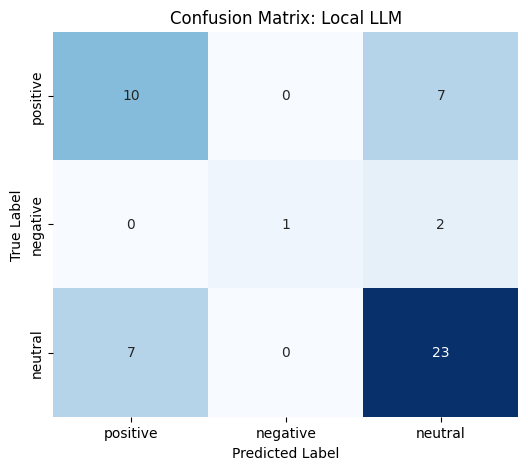

In [9]:
# --- Local LLM Implementation (Phi-2) ---
LLM_MODEL = "microsoft/phi-2"

def local_llm_zero_shot(texts, model_name=LLM_MODEL, sample_size=50):
    """
    Performs zero-shot sentiment classification using a local LLM (Phi-2).
    """
    print(f"\n--- Running Local LLM ({model_name}) Zero-Shot ---")

    texts_subset = texts[:sample_size]

    try:
        # 1. Load Tokenizer and Model separately (FIX for ValueError)
        llm_tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        llm_model = AutoModelForCausalLM.from_pretrained(
            model_name,
            trust_remote_code=True,
            torch_dtype=torch.float16,
            device_map="auto",
            # Pass quantization config directly to the model loading function
            quantization_config=BNB_CONFIG if USE_4BIT else None
        )

        # 2. Create pipeline using the loaded objects
        llm_pipeline = pipeline(
            "text-generation",
            model=llm_model,
            tokenizer=llm_tokenizer
        )
    except Exception as e:
        print(f"Skipping LLM: Model loading failed. Error: {e}")
        return [random.choice(LABEL_ORDER) for _ in texts_subset]

    llm_predictions = []

    # Define a structured prompt template
    def create_zero_shot_prompt(sentence):
        prompt = (
            f"Classify the sentiment of the following financial statement as 'positive', 'negative', or 'neutral'.\n\n"
            f"Statement: \"{sentence}\"\n"
            f"Sentiment: "
        )
        return prompt

    # 1. Generate responses
    for text in tqdm(texts_subset, desc="LLM Zero-Shot"):
        prompt = create_zero_shot_prompt(text)

        output = llm_pipeline(
            prompt,
            max_new_tokens=5,
            do_sample=False,
            temperature=0.0,
            pad_token_id=llm_pipeline.tokenizer.eos_token_id
        )

        response_text = output[0]['generated_text'].replace(prompt, '').strip().lower()

        # 2. Heuristic parsing (extract label)
        if 'positive' in response_text:
            llm_predictions.append('positive')
        elif 'negative' in response_text:
            llm_predictions.append('negative')
        else:
            llm_predictions.append('neutral')

    # Cleanup memory
    del llm_pipeline, llm_model, llm_tokenizer
    if DEVICE == 'cuda':
        torch.cuda.empty_cache()
    gc.collect()

    return llm_predictions

# ----------------------------------------------------
# EXECUTION
# ----------------------------------------------------
# Ensure you have run Section 1 and 3A successfully before this.
try:
    test_sample_size = min(50, len(test_df))
    llm_zero_shot_preds = local_llm_zero_shot(test_df['full_text'].tolist(), sample_size=test_sample_size)
    test_labels_subset = test_labels[:test_sample_size]

    acc, _, _, _ = metric_tool.get_all_metrics(test_labels_subset, llm_zero_shot_preds, f"Local LLM (Zero-Shot) on {test_sample_size} Samples")
    metric_tool.plot_confusion_matrix(test_labels_subset, llm_zero_shot_preds, "Local LLM")
    global_accuracies['Local LLM'] = acc
except NameError:
    print("ERROR: Please ensure you run Section 1 (Data Loading and Feature Preparation) first to define 'test_df', 'test_labels', etc.")

*RAG-Enhanced System (Few-Shot)*


Building RAG Knowledge Base...
RAG Index built with 1811 documents.

--- Running RAG-Enhanced Few-Shot Classification ---


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


RAG Few-Shot:   0%|          | 0/50 [00:00<?, ?it/s]


=== RAG-Enhanced LLM on 50 Samples Performance Metrics ===
Accuracy: 0.6000, Precision: 0.5352, Recall: 0.6000, F1: 0.5069


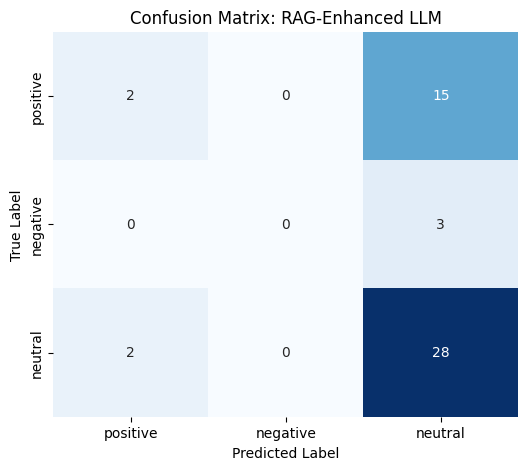



Ready to proceed to Section 4 (Conditional Fine-Tuning).


In [11]:
# --- RAG Implementation (FAISS + Sentence Transformer) ---
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

class RAGSentimentClassifier:
    """Implements Retrieval-Augmented Generation for few-shot sentiment analysis."""

    def __init__(self, train_df, llm_model, llm_tokenizer):
        self.train_df = train_df
        # Reusing the existing encoder setup
        self.encoder = SentenceTransformer('all-MiniLM-L6-v2', device=DEVICE)
        self.llm_model_name = llm_model # Storing name for loading
        self.llm_tokenizer_name = llm_tokenizer

        self.faiss_index = None

    def create_knowledge_base(self):
        """Encodes the training data and builds the FAISS index."""
        print("\nBuilding RAG Knowledge Base...")

        corpus_sentences = self.train_df['full_text'].tolist()
        corpus_labels = self.train_df['sentiment'].tolist()

        # Create embeddings
        sentence_embeddings = self.encoder.encode(
            corpus_sentences,
            convert_to_tensor=True,
            show_progress_bar=False
        ).cpu().numpy()

        embedding_dim = sentence_embeddings.shape[1]

        # Build FAISS Index
        self.faiss_index = faiss.IndexFlatL2(embedding_dim)
        self.faiss_index.add(sentence_embeddings.astype(np.float32))

        self.corpus_data = {
            'sentences': corpus_sentences,
            'labels': corpus_labels
        }
        print(f"RAG Index built with {self.faiss_index.ntotal} documents.")

    def retrieve_context(self, query_text, k=3):
        """Retrieves k nearest neighbors from the knowledge base."""
        query_vector = self.encoder.encode(query_text, convert_to_tensor=True).cpu().numpy().reshape(1, -1)
        distances, indices = self.faiss_index.search(query_vector.astype(np.float32), k)

        retrieved_context = []
        for idx in indices[0]:
            if idx >= 0:
                sentence = self.corpus_data['sentences'][idx]
                label = self.corpus_data['labels'][idx]
                retrieved_context.append(f"Example: '{sentence}' -> Label: {label}")

        return "\n".join(retrieved_context)

    def classify_few_shot(self, texts, k_retrieval=3, sample_size=50):
        """Generates few-shot prompts and uses the LLM for classification."""
        print("\n--- Running RAG-Enhanced Few-Shot Classification ---")
        llm_predictions = []
        texts_subset = texts[:sample_size]

        try:
            # 1. Load Tokenizer and Model separately (The fix)
            llm_tokenizer = AutoTokenizer.from_pretrained(self.llm_tokenizer_name, trust_remote_code=True)
            llm_model = AutoModelForCausalLM.from_pretrained(
                self.llm_model_name,
                trust_remote_code=True,
                torch_dtype=torch.float16,
                device_map="auto",
                # quantization_config is correctly passed here
                quantization_config=BNB_CONFIG if USE_4BIT else None
            )

            # 2. Create LLM pipeline
            llm_pipeline = pipeline(
                "text-generation",
                model=llm_model,
                tokenizer=llm_tokenizer
                # No quantization_config here
            )
        except Exception as e:
            print(f"Skipping RAG: LLM resource issue. Error: {e}")
            return [random.choice(LABEL_ORDER) for _ in texts_subset]

        for text in tqdm(texts_subset, desc="RAG Few-Shot"):
            # 1. Retrieve context
            context = self.retrieve_context(text, k=k_retrieval)

            # 2. Create Few-Shot Prompt
            few_shot_prompt = (
                f"You are an expert financial sentiment analyst. Use the provided Context Examples to classify the final Statement.\n\n"
                f"Context Examples:\n{context}\n\n"
                f"Task: Classify the sentiment of the statement below as 'positive', 'negative', or 'neutral'.\n"
                f"Statement: \"{text}\"\n"
                f"Predicted Sentiment (only the word): "
            )

            # 3. Generate response
            output = llm_pipeline(
                few_shot_prompt,
                max_new_tokens=5,
                do_sample=False,
                temperature=0.0,
                pad_token_id=llm_pipeline.tokenizer.eos_token_id
            )

            response_text = output[0]['generated_text'].replace(few_shot_prompt, '').strip().lower()

            # 4. Heuristic parsing
            if 'positive' in response_text:
                llm_predictions.append('positive')
            elif 'negative' in response_text:
                llm_predictions.append('negative')
            else:
                llm_predictions.append('neutral')

        # Cleanup memory
        del llm_pipeline, llm_model, llm_tokenizer
        if DEVICE == 'cuda':
            torch.cuda.empty_cache()
        gc.collect()

        return llm_predictions

# ----------------------------------------------------
# EXECUTION
# ----------------------------------------------------
try:
    rag_system = RAGSentimentClassifier(train_df, LLM_MODEL, LLM_MODEL)
    rag_system.create_knowledge_base()

    # Reuse test_sample_size from 3B execution
    rag_preds = rag_system.classify_few_shot(test_df['full_text'].tolist(), k_retrieval=3, sample_size=test_sample_size)

    acc, _, _, _ = metric_tool.get_all_metrics(test_labels_subset, rag_preds, f"RAG-Enhanced LLM on {test_sample_size} Samples")
    metric_tool.plot_confusion_matrix(test_labels_subset, rag_preds, "RAG-Enhanced LLM")
    global_accuracies['RAG-Enhanced LLM'] = acc

    # Now proceed to Section 4
    print("\n\nReady to proceed to Section 4 (Conditional Fine-Tuning).")
except NameError:
    print("ERROR: Please ensure you run Sections 1, 2, 3A, and the corrected 3B successfully before this.")

Comparative Analysis & Conditional Fine-Tuning

In [12]:
# --- Conditional Fine-Tuning ---
from transformers import Trainer, TrainingArguments

MAX_ACCURACY = max(global_accuracies.values())

print("\n--- Conditional Fine-Tuning Decision ---")
print(f"Max achieved accuracy: {MAX_ACCURACY:.4f}")

# Define a custom dataset class (for PyTorch Trainer)
class FinetuningDataset(torch.utils.data.Dataset):
    """A custom PyTorch Dataset for FinBERT fine-tuning."""

    def __init__(self, texts, labels, tokenizer, label_map, max_len=128):
        self.texts = texts
        self.labels = [label_map[l] for l in labels]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

if MAX_ACCURACY < 0.90:
    print("\n--- Fine-Tuning Condition Met (Accuracy < 90%) ---")
    print("Starting FinBERT fine-tuning on the full training set.")

    gc.collect()
    if DEVICE == 'cuda':
        torch.cuda.empty_cache()

    # 1. Setup Model and Tokenizer
    finetune_tokenizer = AutoTokenizer.from_pretrained(FINBERT_MODEL)
    finetune_model = AutoModelForSequenceClassification.from_pretrained(
        FINBERT_MODEL,
        num_labels=len(SENTIMENT_MAP)
    ).to(DEVICE)

    # 2. Prepare Datasets (using full train/test sets)
    ft_train_ds = FinetuningDataset(
        train_df['full_text'].tolist(),
        train_df['sentiment'].tolist(),
        finetune_tokenizer,
        SENTIMENT_MAP
    )
    ft_test_ds = FinetuningDataset(
        test_df['full_text'].tolist(),
        test_df['sentiment'].tolist(),
        finetune_tokenizer,
        SENTIMENT_MAP
    )

    # 3. Define Training Arguments
    training_args = TrainingArguments(
        output_dir='./finetune_checkpoints_dlp',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        learning_rate=2e-5,
        logging_steps=10,
        evaluation_strategy="no",
        save_strategy="epoch",
        load_best_model_at_end=False,
        report_to="none"
    )

    # 4. Initialize and Run Trainer
    finetune_trainer = Trainer(
        model=finetune_model,
        args=training_args,
        train_dataset=ft_train_ds,
        tokenizer=finetune_tokenizer
    )

    print("\nStarting model training...")
    finetune_trainer.train()

    # 5. Final Evaluation on Test Set
    print("\nEvaluating Fine-Tuned Model...")

    predictions_output = finetune_trainer.predict(ft_test_ds)

    predicted_indices = np.argmax(predictions_output.predictions, axis=1)
    final_ft_preds = [INV_SENTIMENT_MAP[x] for x in predicted_indices]

    # Report metrics
    final_acc, _, _, _ = metric_tool.get_all_metrics(test_labels, final_ft_preds, "Fine-Tuned FinBERT")
    metric_tool.plot_confusion_matrix(test_labels, final_ft_preds, "Fine-Tuned FinBERT")
    global_accuracies['Fine-Tuned FinBERT'] = final_acc

    # Cleanup memory
    del finetune_model, finetune_tokenizer, finetune_trainer
    if DEVICE == 'cuda':
        torch.cuda.empty_cache()

else:
    print("Accuracy >= 90%. Fine-tuning skipped as per assignment rule.")

print("\n--- Pipeline Execution Complete ---")


--- Conditional Fine-Tuning Decision ---
Max achieved accuracy: 0.9691
Accuracy >= 90%. Fine-tuning skipped as per assignment rule.

--- Pipeline Execution Complete ---
